In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/ext_navish_iitkgp_gmail_com/ganRegression/')

#### Hexagonal Level Dataset

In [2]:
import numpy as np
import os
from functools import partial
import seaborn as sns
import plotly.graph_objects as go
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import sys
import pickle
from pathlib import Path
import pandas as pd


# hex2vec
HOME = os.environ["HOME"]

sys.path.insert(0, f"{HOME}/hex2vec")

# add codebase
sys.path.insert(0, f"/gcsmount-notebook/codebase")

from src.data.make_dataset import h3_to_polygon
import urban_tools.constants as uc
from urban_tools.hex_pipeline import RouteHexHandler, TestTrainManager
from urban_tools.pipelines import route_hex_pipeline


## Read in the Delivery DataFrame
# p = Path("/gcsmount-research-data-staging/osmnx-cities/hexed-routes/11.23.22/hh.pkl")
# p = Path("/gcsmount-research-data-staging/osmnx-cities/hexed-routes/11.29.22-No-Outlier-Tags-Boston/hh.pkl")
p = Path("/gcsmount-research-data-staging/osmnx-cities/hexed-routes/11.29.22-All-Tags-No-Tukey/hh.pkl")
hh = RouteHexHandler.from_pickle(p)


hh.df = hh.df.loc[hh.df.city.str.contains("Boston")]

# ---------------------------------------
percentage = 0.01

drop_cols = pd.Index([])
for _hh in [hh]:
    assert _hh.df["city"].unique().shape[0] == 1
    h3_df = _hh.df.groupby('h3')[_hh.all_tags].first()
    percent_occurance = (h3_df > 0).sum() / h3_df.shape[0]
    drop_cols = drop_cols.union(percent_occurance[percent_occurance < percentage].index)
hh.drop_cols(drop_cols)

# embedding_df = pd.read_pickle("/gcsmount-research-data-staging/osmnx-cities/hexed-complete/Boston, MA/boston_embedding.pkl")

### Remove Super Tags
# hh.drop_super_tags()
### Remove Sub Tags
# hh = hh.drop_sub_tags()
### Filter for only H3 with > X Data Points

hh = hh.filter_hex_occurance(20)
## Drop Unecessary Columns
hh.other_tags
### Drop Chicago
# print(tagged_df.shape[0].compute(), tagged_df.shape[1])
# tagged_df = tagged_df.loc[~tagged_df["city"].str.contains("Chicago")]
# filter for only Boston
hh.df = hh.df.loc[hh.df.city.str.contains("Boston")]
hh.drop_zero_tags()
# print(tagged_df.shape[0].compute(), tagged_df.shape[1])

## Data Preprocessing: Scaling and Splitting into train test


# create a grouped dataframe
tagged_df = hh.df.groupby("h3").agg({
    "planned_service_time_log": "mean",
    **{
        tag: "first"
        for tag in hh.all_tags
    }
})


from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

tt = TestTrainManager(
    hh.df,  # pass in the ungrouped dataframe aka raw
    x_col=hh.all_tags, 
    y_col=["planned_service_time_log"],
    # scaler=RobustScaler,
    scaler=StandardScaler,
    # scaler=MinMaxScaler,
    aggregate=True, # tell the manager to do the aggregation internally
    add_variance=True, # tell the manager to add the variance
)

tt.split_test_train()
tt.scale_test_train()
tt.build_test_df()

print(f'Training Data shape is {tt.X_train.shape}')
print(f'testing Data shape is {tt.X_test.shape}')

Aggregating Data
Training Data shape is (957, 134)
testing Data shape is (240, 134)


In [3]:
hh.print_history()

read_cities(*(PosixPath('/gcsmount-research-data-staging/osmnx-cities/hexed-complete'),), **{'cities': ['Boston, USA', 'Austin, USA', 'Seattle, USA', 'Los Angeles, USA'], 'add_city_col': True})
create_super_tags(*(), **{})
add_new_special_tag(*('building.area.ratio',), **{})
drop_zero_building_area(*(), **{})
add_new_special_tag(*('building.area.average',), **{})
add_new_special_tag(*('parking.area.ratio',), **{})
add_new_special_tag(*('parking.area.average',), **{})
append_route_df(*(), **{'route_file': PosixPath('/gcsmount-research-data-staging/almrrc2021-raw/data/almrrc2021-data-training/model_build_inputs/route_df_merged_augmented.parquet'), 'grouped': False, 'tukey_fences': False})
open_route_df(*(PosixPath('/gcsmount-research-data-staging/almrrc2021-raw/data/almrrc2021-data-training/model_build_inputs/route_df_merged_augmented.parquet'), False, False), **{})
filter_hex_occurance(*(), **{'min': 10})
drop_zero_tags(*(), **{})
drop_special_tags(*({},), **{})
filter_hex_occurance(*(2

<AxesSubplot: >

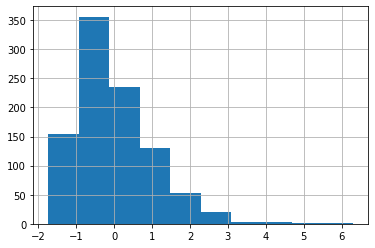

In [4]:
tt.X_train.building.hist()

In [58]:
X_train, y_train, X_test, y_test = tt.X_train.values, tt.Y_train.planned_service_time_log_mean.values.ravel(), tt.X_test.values, tt.Y_test.loc.values

## PCA

In [6]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
import statistics as stat
from sklearn.linear_model import LinearRegression
import math
from sklearn import metrics
%matplotlib inline

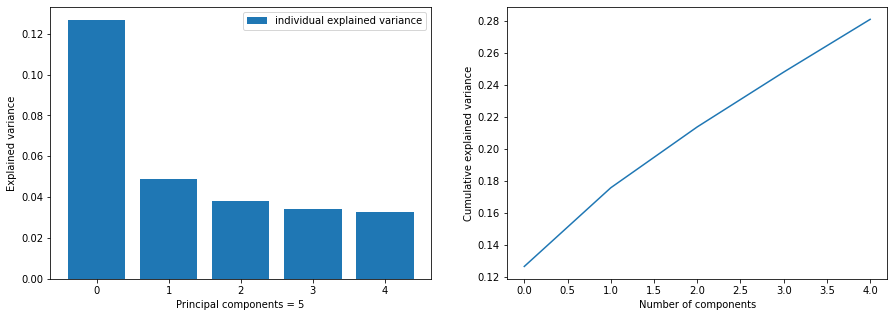

In [7]:
# n_components = X_train.shape[1]
n_components = 5
pca = PCA(n_components=n_components)
# pca = KernelPCA(n_components=n_components, kernel='rbf', gamma=0.1)
X_pca = pca.fit_transform(X_train)
explained_variance=pca.explained_variance_ratio_

# explained_variance = np.var(X_pca, axis=0) / np.sum(np.var(X_pca, axis=0))

# create subplots for cumulative explained variance and individual explained variance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# plot individual explained variance
ax1.bar(range(n_components), explained_variance, label='individual explained variance')
ax1.set_xlabel(f'Principal components = {n_components}')
ax1.set_ylabel('Explained variance')
ax1.legend()

# plot cumulative explained variance
ax2.plot(np.cumsum(explained_variance))
ax2.set_xlabel('Number of components')
ax2.set_ylabel('Cumulative explained variance')

plt.show()


## Modelling using GP Regression

In [8]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

# Make plots inline
%matplotlib inline

In [9]:
# data_dim = X_train.shape[1]

# # Same architechture as the MLP neural network
# class LargeFeatureExtractor(torch.nn.Sequential):
#     def __init__(self):
#         super(LargeFeatureExtractor, self).__init__()
#         self.add_module('linear1', torch.nn.Linear(data_dim, 16))
#         self.add_module('relu1', torch.nn.ReLU())
#         self.add_module('linear2', torch.nn.Linear(16, 32))
#         self.add_module('relu2', torch.nn.ReLU())
#         self.add_module('linear3', torch.nn.Linear(32, 128))
#         self.add_module('relu3', torch.nn.ReLU())
#         self.add_module('linear4', torch.nn.Linear(128, 32))
#         self.add_module('relu4', torch.nn.ReLU())
#         self.add_module('linear5', torch.nn.Linear(32, 16))
#         self.add_module('relu5', torch.nn.ReLU())
#         self.add_module('linear6', torch.nn.Linear(16, 2))

# feature_extractor = LargeFeatureExtractor()

In [10]:
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.base_covar_module = gpytorch.kernels.RBFKernel()
            # works but extremely slow even for 5 PCA dimensions!
            # self.covar_module = gpytorch.kernels.GridInterpolationKernel(
            #     gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=n_components)),
            #     num_dims=n_components, grid_size=16
            # )
            # AdditiveStructureKernel
            self.covar_module = gpytorch.kernels.AdditiveStructureKernel(
            gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.GridInterpolationKernel(self.base_covar_module, grid_size=256, num_dims=1)
            ), num_dims=n_components
            )
            # This leads to crashing of the kernel :/
            # gpytorch.kernels.GridInterpolationKernel(
            #     gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=n_components)),
            #     num_dims=n_components, grid_size=64
            # )
            # self.feature_extractor = feature_extractor

            # PCA based feature extractor
            self.feature_extractor = PCA(n_components=n_components)

            # This module will scale the NN features so that they're nice values
            self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            # projected_x = self.feature_extractor(x)
            projected_x = torch.Tensor(self.feature_extractor.fit_transform(x))
            projected_x = self.scale_to_bounds(projected_x)  # Make the NN values "nice"

            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [11]:
from tqdm import tqdm
training_iterations = 1000

# load the saved model
# state_dict = torch.load('model_state.pth')

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(torch.Tensor(X_train), torch.Tensor(y_train), likelihood)

# model.load_state_dict(state_dict)

if torch.cuda.is_available():
    model = model
    likelihood = likelihood

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    # {'params': model.feature_extractor.parameters()},
    {'params': model.covar_module.parameters()},
    {'params': model.mean_module.parameters()}, 
    {'params': model.likelihood.parameters()},
], lr=1e-2)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

train_losses = []

def train():
    iterator = tqdm(range(training_iterations))
    for i in iterator:
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(torch.Tensor(X_train))
        # Calc loss and backprop derivatives
        loss = -mll(output, torch.Tensor(y_train))
        loss.backward()
        train_losses.append(loss.item())
        iterator.set_postfix(loss=loss.item())
        optimizer.step()

%time train()

100%|██████████| 1000/1000 [03:41<00:00,  4.52it/s, loss=1.09]

CPU times: user 15min 31s, sys: 8min 23s, total: 23min 54s
Wall time: 3min 41s


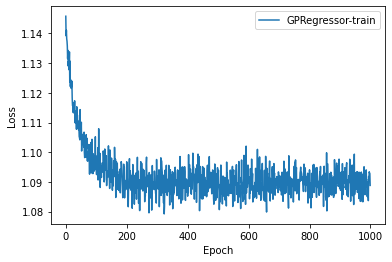

In [12]:
# plot the loss
plt.plot(train_losses, label='GPRegressor-train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    training_preds = model(torch.Tensor(X_train))

with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    preds = model(torch.Tensor(X_test))

/home/ext_navish_iitkgp_gmail_com/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


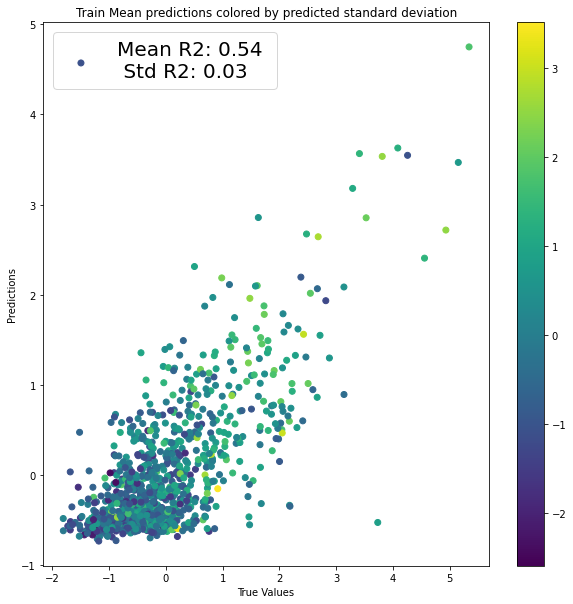

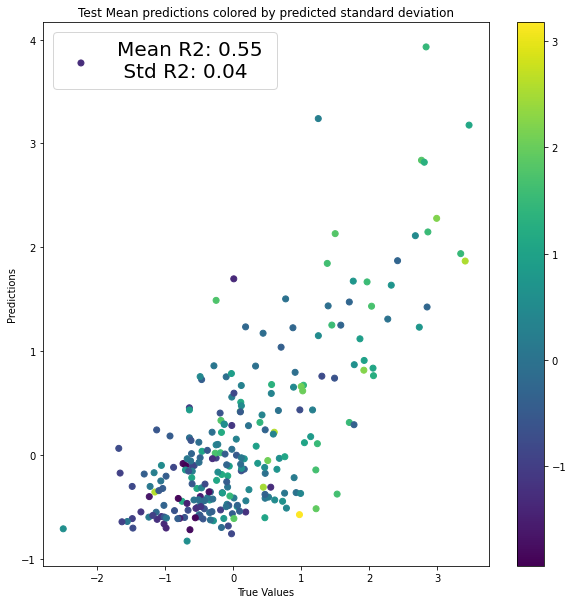

In [14]:
from sklearn.metrics import r2_score

def scatter_plot(y_test, y_pred, y_test_std = tt.Y_test.scale, y_pred_std = tt.Y_test.scale.values, bool = True, title = ''):
    
    plt.figure(figsize=(10, 10))
    if bool == True:
        plt.scatter(y_test, y_pred, c=y_test_std, cmap='viridis', label=f'Mean R2: {r2_score(y_test, y_pred):.2f} \n Std R2: {r2_score(y_test_std, y_pred_std):.2f}')
    else:
        plt.scatter(y_test, y_pred, c=y_pred_std, cmap='viridis', label=f'Mean R2: {r2_score(y_test, y_pred):.2f}')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(title)
    plt.colorbar()
    plt.legend(fontsize=20)
    plt.ticklabel_format(style='plain')
    plt.show() 

scatter_plot(y_train, training_preds.mean, tt.Y_train.planned_service_time_log_std, training_preds.variance**0.5, bool = True, title = 'Train Mean predictions colored by predicted standard deviation')
scatter_plot(y_test, preds.mean, tt.Y_test.scale, preds.variance**0.5, bool = True, title = 'Test Mean predictions colored by predicted standard deviation')

In [15]:
print('Mean-predicitions')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, training_preds.mean):.3f}, Train RMSE: {mean_squared_error(torch.Tensor(y_train), training_preds.mean, squared=False):.3f}, Train R2: {r2_score(torch.Tensor(y_train), training_preds.mean):.3f}')
print(f'Test MAPE: {mean_absolute_percentage_error(y_test, preds.mean):.3f}, Test RMSE: {mean_squared_error(torch.Tensor(y_test), preds.mean, squared=False):.3f}, Test R2: {r2_score(torch.Tensor(y_test), preds.mean):.3f}')
print('-'*50)
print('Variance-predicitions')
print(f'Train MAPE: {mean_absolute_percentage_error(tt.Y_train.planned_service_time_log_std, training_preds.variance**0.5):.3f}, Train RMSE: {mean_squared_error(tt.Y_train.planned_service_time_log_std, training_preds.variance**0.5, squared=False):.3f}, Train R2: {r2_score(tt.Y_train.planned_service_time_log_std, training_preds.variance**0.5):.3f}')
print(f'Test MAPE: {mean_absolute_percentage_error(tt.Y_test.scale, preds.variance**0.5):.3f}, Test RMSE: {mean_squared_error(tt.Y_test.scale, preds.variance**0.5, squared=False):.3f}, Test R2: {r2_score(tt.Y_test.scale, preds.variance**0.5):.3f}')


torch.save(model.state_dict(), 'model_state.pth')

Mean-predicitions
Train MAPE: 20.793, Train RMSE: 0.681, Train R2: 0.536
Test MAPE: 3.970, Test RMSE: 0.719, Test R2: 0.547
--------------------------------------------------
Variance-predicitions
Train MAPE: 1.222, Train RMSE: 0.983, Train R2: 0.033
Test MAPE: 1.854, Test RMSE: 0.955, Test R2: 0.045


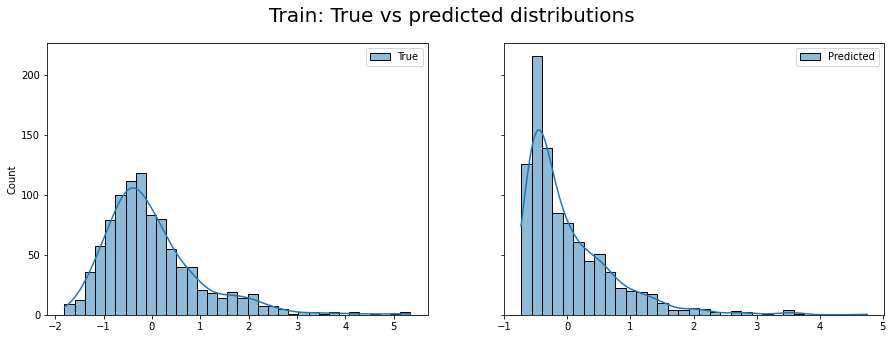

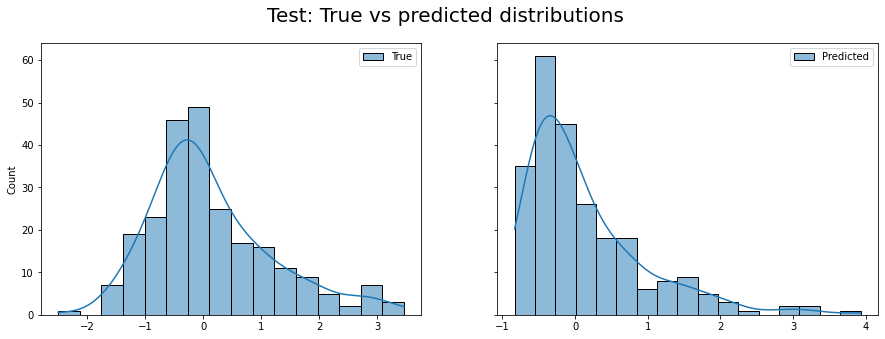

In [16]:
#  plot density of the predictions
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Train: True vs predicted distributions', fontsize=20)

sns.histplot(y_train, ax=axes[0], kde=True, label='True')
axes[0].legend()
sns.histplot(training_preds.mean, ax=axes[1], kde=True, label='Predicted')
axes[1].legend()

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Test: True vs predicted distributions', fontsize=20)

sns.histplot(y_test, ax=axes[0], kde=True, label='True')
axes[0].legend()
sns.histplot(preds.mean, ax=axes[1], kde=True, label='Predicted')
axes[1].legend()

## Quantile coverage error 

In [21]:
model.eval()
with torch.no_grad():
    trained_pred_dist = likelihood(model(torch.Tensor(X_test)))
    predictive_mean = trained_pred_dist.mean
    lower, upper = trained_pred_dist.confidence_region()

/home/ext_navish_iitkgp_gmail_com/.local/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


In [22]:
quantile = 95
qce = gpytorch.metrics.quantile_coverage_error(trained_pred_dist, torch.Tensor(y_test), quantile=quantile)
print(f'Quantile {quantile}% Coverage Error: {qce:.2f}')

Quantile 95% Coverage Error: 0.94


## Quantile/Conformal Predictions using 5-PCA components
### 1. First estimation of the uncertainties with MAPIE

In [170]:
from typing_extensions import TypedDict
from typing import Union
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,DotProduct,ConstantKernel
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    RobustScaler
)
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mapie.metrics import regression_coverage_score
from mapie.regression import MapieRegressor
from mapie.subsample import Subsample

warnings.filterwarnings("ignore")

In [259]:
def get_regressor(name):
    if name == "linear":
        mdl = LinearRegression()
        
    elif name == "polynomial":
        degree_polyn = 2
        mdl = Pipeline(
            [
                ("poly", PolynomialFeatures(degree=degree_polyn)),
                ("linear", LinearRegression())
            ]
        )
    elif name == "random_forest":
        mdl = RandomForestRegressor()

    elif name == "xgb":
        mdl = XGBRegressor()

    elif name == "gp":
        kernel_skl = ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0)) * RBF(length_scale=1, length_scale_bounds=(0.0, 10.0)) + RBF(length_scale=2, length_scale_bounds=(0.0, 10.0))
        mdl = GaussianProcessRegressor(kernel_skl,\
                                  copy_X_train=False,
                                  normalize_y=True)
    
    return mdl

In [260]:
mdl = get_regressor("gp")
# mdl = get_regressor("random_forest")

In [261]:
mapie = MapieRegressor(mdl, method="plus", cv=KFold(n_splits=5, shuffle=True))

In [262]:
mapie.fit(X_pca, y_train)

MapieRegressor(cv=KFold(n_splits=5, random_state=None, shuffle=True),
               estimator=GaussianProcessRegressor(copy_X_train=False,
                                                  kernel=1**2 * RBF(length_scale=1) + RBF(length_scale=2),
                                                  normalize_y=True))

In [276]:
alpha

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [263]:
alpha = np.arange(0.05, 1, 0.05)
y_train_pred, y_train_pis = mapie.predict(X_pca, alpha=alpha)
y_test_pred, y_test_pis = mapie.predict(pca.fit_transform(X_test), alpha=alpha)

In [264]:
print('Mean-predicitions')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, y_train_pred):.3f}, Train RMSE: {mean_squared_error(y_train, y_train_pred, squared=False):.3f}, Train R2: {r2_score(y_train, y_train_pred):.3f}')
print(f'Test MAPE: {mean_absolute_percentage_error(y_test, y_test_pred):.3f}, Test RMSE: {mean_squared_error(y_test, y_test_pred, squared=False):.3f}, Test R2: {r2_score(y_test, y_test_pred):.3f}')
print('-'*50)
# print('Variance-predicitions')
# print(f'Train MAPE: {mean_absolute_percentage_error(tt.Y_train.planned_service_time_log_std, training_preds.variance**0.5):.3f}, Train RMSE: {mean_squared_error(tt.Y_train.planned_service_time_log_std, training_preds.variance**0.5, squared=False):.3f}, Train R2: {r2_score(tt.Y_train.planned_service_time_log_std, training_preds.variance**0.5):.3f}')
# print(f'Test MAPE: {mean_absolute_percentage_error(tt.Y_test.scale, preds.variance**0.5):.3f}, Test RMSE: {mean_squared_error(tt.Y_test.scale, preds.variance**0.5, squared=False):.3f}, Test R2: {r2_score(tt.Y_test.scale, preds.variance**0.5):.3f}')

Mean-predicitions
Train MAPE: 0.000, Train RMSE: 0.000, Train R2: 1.000
Test MAPE: 2.892, Test RMSE: 0.796, Test R2: 0.445
--------------------------------------------------


In [265]:
def plot_predictionintervals(
    y_train,
    y_train_pred,
    y_train_pred_low,
    y_train_pred_high,
    y_test,
    y_test_pred,
    y_test_pred_low,
    y_test_pred_high,
    suptitle: str,
) -> None:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    ax1.errorbar(
        x=y_train,
        y=y_train_pred,
        yerr=(y_train_pred - y_train_pred_low, y_train_pred_high - y_train_pred),
        alpha=0.8,
        label="train",
        fmt=".",
    )
    ax1.errorbar(
        x=y_test,
        y=y_test_pred,
        yerr=(y_test_pred - y_test_pred_low, y_test_pred_high - y_test_pred),
        alpha=0.8,
        label="test",
        fmt=".",
    )
    ax1.plot(
        [y_train.min(), y_train.max()],
        [y_train.min(), y_train.max()],
        color="gray",
        alpha=0.5,
    )
    ax1.set_xlabel("True values", fontsize=12)
    ax1.set_ylabel("Predicted values", fontsize=12)
    ax1.legend()
    
    ax2.scatter(
        x=y_train, y=y_train_pred_high - y_train_pred_low, alpha=0.8, label="train", marker="."
    )
    ax2.scatter(x=y_test, y=y_test_pred_high - y_test_pred_low, alpha=0.8, label="test", marker=".")
    ax2.set_xlabel("True values", fontsize=12)
    ax2.set_ylabel("Interval width", fontsize=12)
    ax2.set_xscale("linear")
    ax2.set_ylim([0, np.max(y_test_pred_high - y_test_pred_low)*1.1])
    ax2.legend()
    std_all = np.concatenate([
        y_train_pred_high - y_train_pred_low, y_test_pred_high - y_test_pred_low
    ])
    type_all = np.array(["train"] * len(y_train) + ["test"] * len(y_test))
    x_all = np.arange(len(std_all))
    order_all = np.argsort(std_all)
    std_order = std_all[order_all]
    type_order = type_all[order_all]
    ax3.scatter(
        x=x_all[type_order == "train"],
        y=std_order[type_order == "train"],
        alpha=0.8,
        label="train",
        marker=".",
    )
    ax3.scatter(
        x=x_all[type_order == "test"],
        y=std_order[type_order == "test"],
        alpha=0.8,
        label="test",
        marker=".",
    )
    ax3.set_xlabel("Order", fontsize=12)
    ax3.set_ylabel("Interval width", fontsize=12)
    ax3.legend()
    ax1.set_title("True vs predicted values")
    ax2.set_title("Prediction interval width vs true values")
    ax3.set_title("Ordered prediction interval width")
    plt.suptitle(suptitle, size=20)
    plt.show()

### Prediction intervals for alpha=0.05

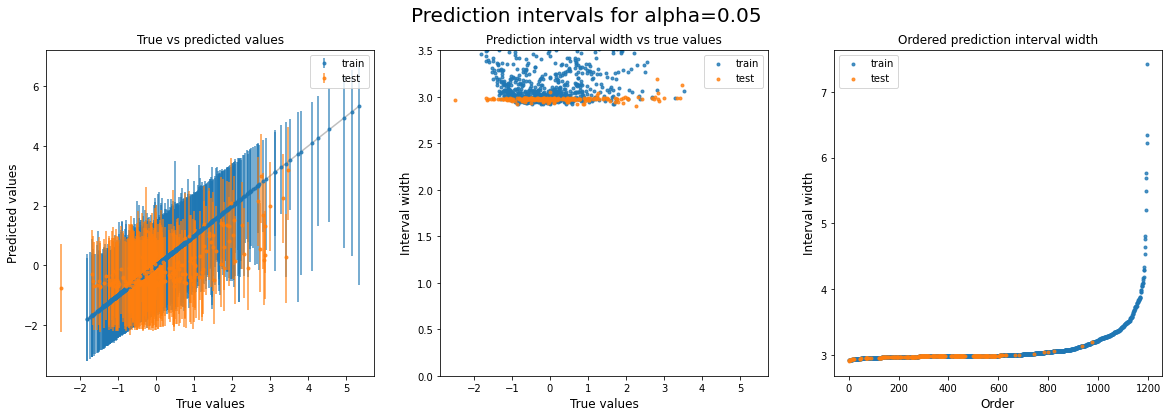

In [285]:
ap = 0.05
alpha_plot = int(np.where(alpha == ap)[0])
plot_predictionintervals(
    y_train,
    y_train_pred,
    y_train_pis[:, 0, alpha_plot],
    y_train_pis[:, 1, alpha_plot],
    y_test,
    y_test_pred,
    y_test_pis[:, 0, alpha_plot],
    y_test_pis[:, 1, alpha_plot],
    f"Prediction intervals for alpha={ap}",
)

### Prediction intervals for alpha=0.1

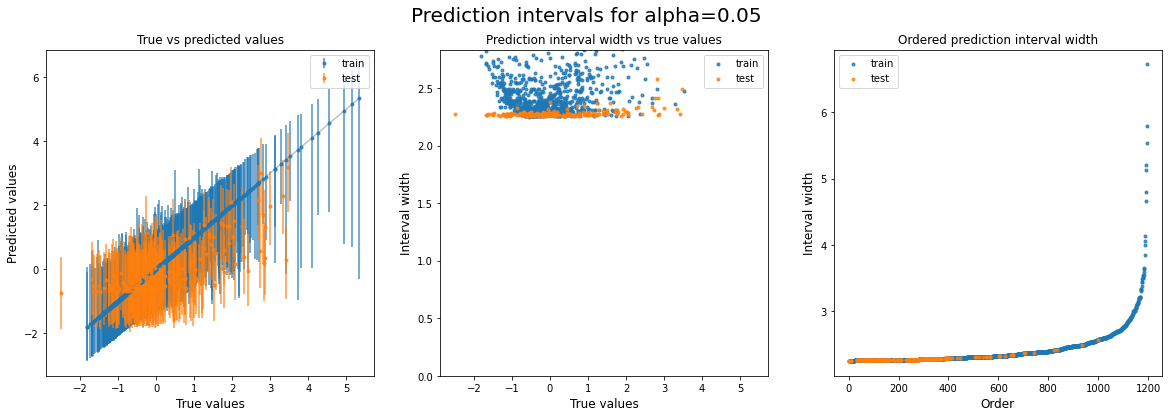

In [286]:
alpha_plot = int(np.where(alpha == 0.1)[0])
plot_predictionintervals(
    y_train,
    y_train_pred,
    y_train_pis[:, 0, alpha_plot],
    y_train_pis[:, 1, alpha_plot],
    y_test,
    y_test_pred,
    y_test_pis[:, 0, alpha_plot],
    y_test_pis[:, 1, alpha_plot],
    f"Prediction intervals for alpha={ap}",
)

### Prediction intervals for alpha=0.2

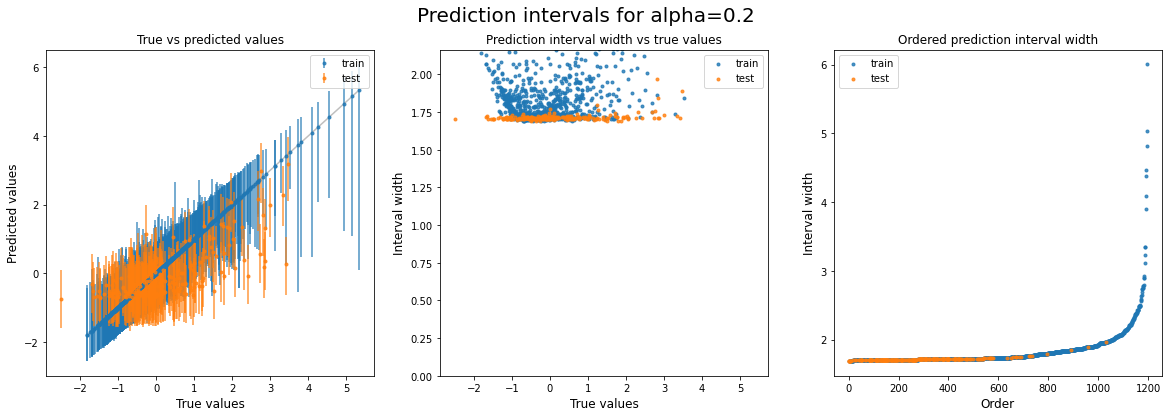

In [287]:
ap = 0.2
alpha_plot = int(np.where(alpha == ap)[0])
plot_predictionintervals(
    y_train,
    y_train_pred,
    y_train_pis[:, 0, alpha_plot],
    y_train_pis[:, 1, alpha_plot],
    y_test,
    y_test_pred,
    y_test_pis[:, 0, alpha_plot],
    y_test_pis[:, 1, alpha_plot],
    f"Prediction intervals for alpha={ap}",
)

### Prediction intervals for alpha=0.3

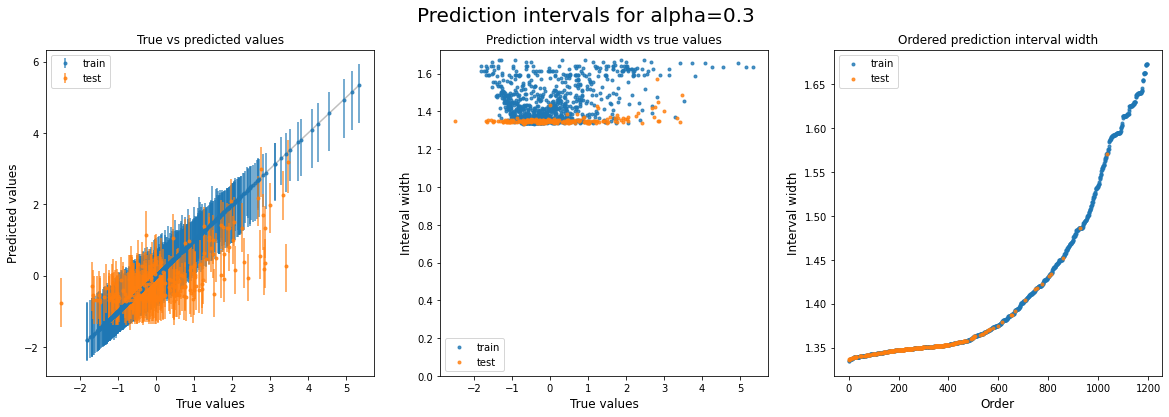

In [288]:
ap = 0.3
alpha_plot = int(np.where(alpha == ap)[0])
plot_predictionintervals(
    y_train,
    y_train_pred,
    y_train_pis[:, 0, alpha_plot],
    y_train_pis[:, 1, alpha_plot],
    y_test,
    y_test_pred,
    y_test_pis[:, 0, alpha_plot],
    y_test_pis[:, 1, alpha_plot],
    f"Prediction intervals for alpha={ap}",
)

### Prediction intervals for alpha=0.4

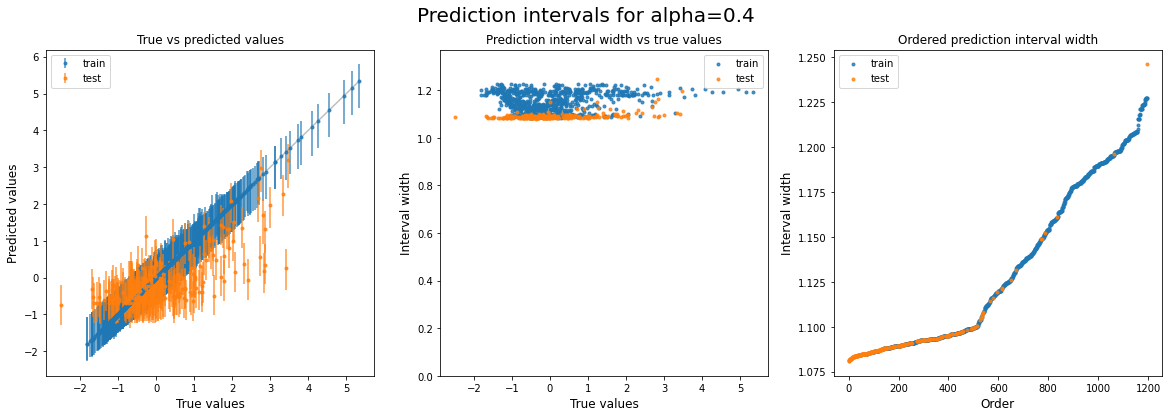

In [289]:
ap = 0.4
alpha_plot = int(np.where(alpha == ap)[0])
plot_predictionintervals(
    y_train,
    y_train_pred,
    y_train_pis[:, 0, alpha_plot],
    y_train_pis[:, 1, alpha_plot],
    y_test,
    y_test_pred,
    y_test_pis[:, 0, alpha_plot],
    y_test_pis[:, 1, alpha_plot],
    f"Prediction intervals for alpha={ap}",
)

### Prediction intervals for alpha=0.5

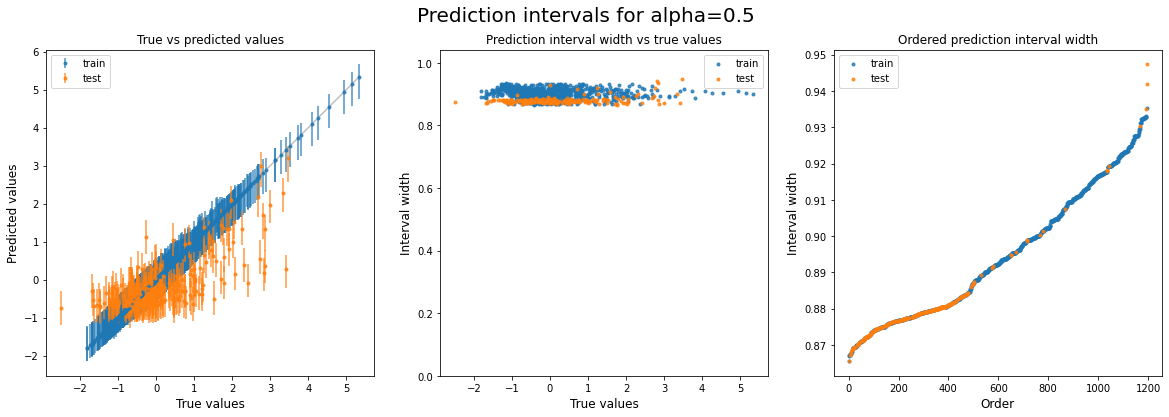

In [290]:
ap = 0.5
alpha_plot = int(np.where(alpha == ap)[0])
plot_predictionintervals(
    y_train,
    y_train_pred,
    y_train_pis[:, 0, alpha_plot],
    y_train_pis[:, 1, alpha_plot],
    y_test,
    y_test_pred,
    y_test_pis[:, 0, alpha_plot],
    y_test_pis[:, 1, alpha_plot],
    f"Prediction intervals for alpha={ap}",
)

### Prediction intervals for alpha=0.7

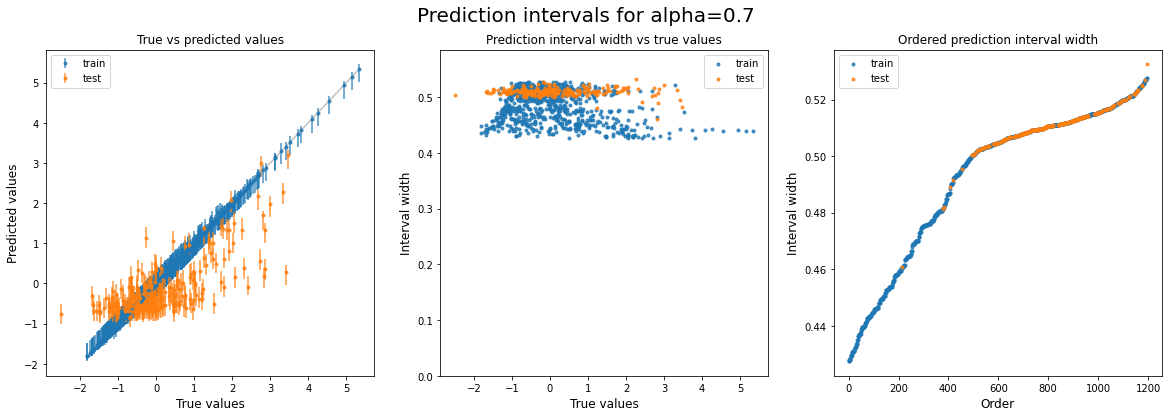

In [333]:
ap = 0.7
alpha_plot = int(np.where(alpha >= ap)[0][0])
plot_predictionintervals(
    y_train,
    y_train_pred,
    y_train_pis[:, 0, alpha_plot],
    y_train_pis[:, 1, alpha_plot],
    y_test,
    y_test_pred,
    y_test_pis[:, 0, alpha_plot],
    y_test_pis[:, 1, alpha_plot],
    f"Prediction intervals for alpha={ap}",
)

###  Comparison of the uncertainty quantification methods

In [280]:
Params = TypedDict("Params", {"method": str, "cv": Union[int, Subsample]})
STRATEGIES = {
    "naive": Params(method="naive"),
    "cv": Params(method="base", cv=5),
    "cv_plus": Params(method="plus", cv=5),
    "cv_minmax": Params(method="minmax", cv=5),
    "jackknife_plus_ab": Params(method="plus", cv=Subsample(n_resamplings=20)),
}
mdl = get_regressor("gp")

In [281]:
y_pred, y_pis, scores = {}, {}, {}
for strategy, params in STRATEGIES.items():
    mapie = MapieRegressor(mdl, **params)
    mapie.fit(X_pca, y_train)
    y_pred[strategy], y_pis[strategy] = mapie.predict(pca.fit_transform(X_test), alpha=alpha)
    scores[strategy] = [
        regression_coverage_score(y_test, y_pis[strategy][:, 0, i], y_pis[strategy][:, 1, i])
        for i, _ in enumerate(alpha)
    ]

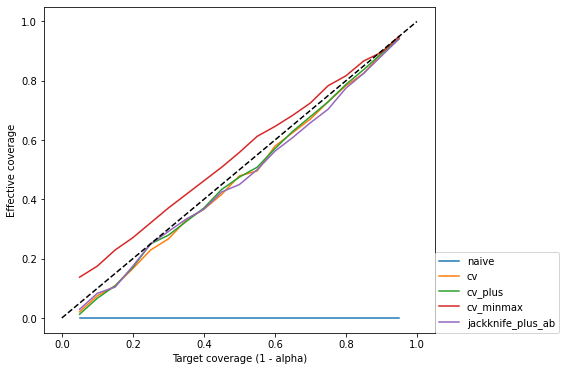

In [282]:
plt.figure(figsize=(7, 6))
plt.xlabel("Target coverage (1 - alpha)")
plt.ylabel("Effective coverage")
for strategy, params in STRATEGIES.items():
    plt.plot(1 - alpha, scores[strategy], label=strategy)
plt.plot([0, 1], [0, 1], ls="--", color="k")
plt.legend(loc=[1, 0])

## Plot for real service times vs hex-IDs

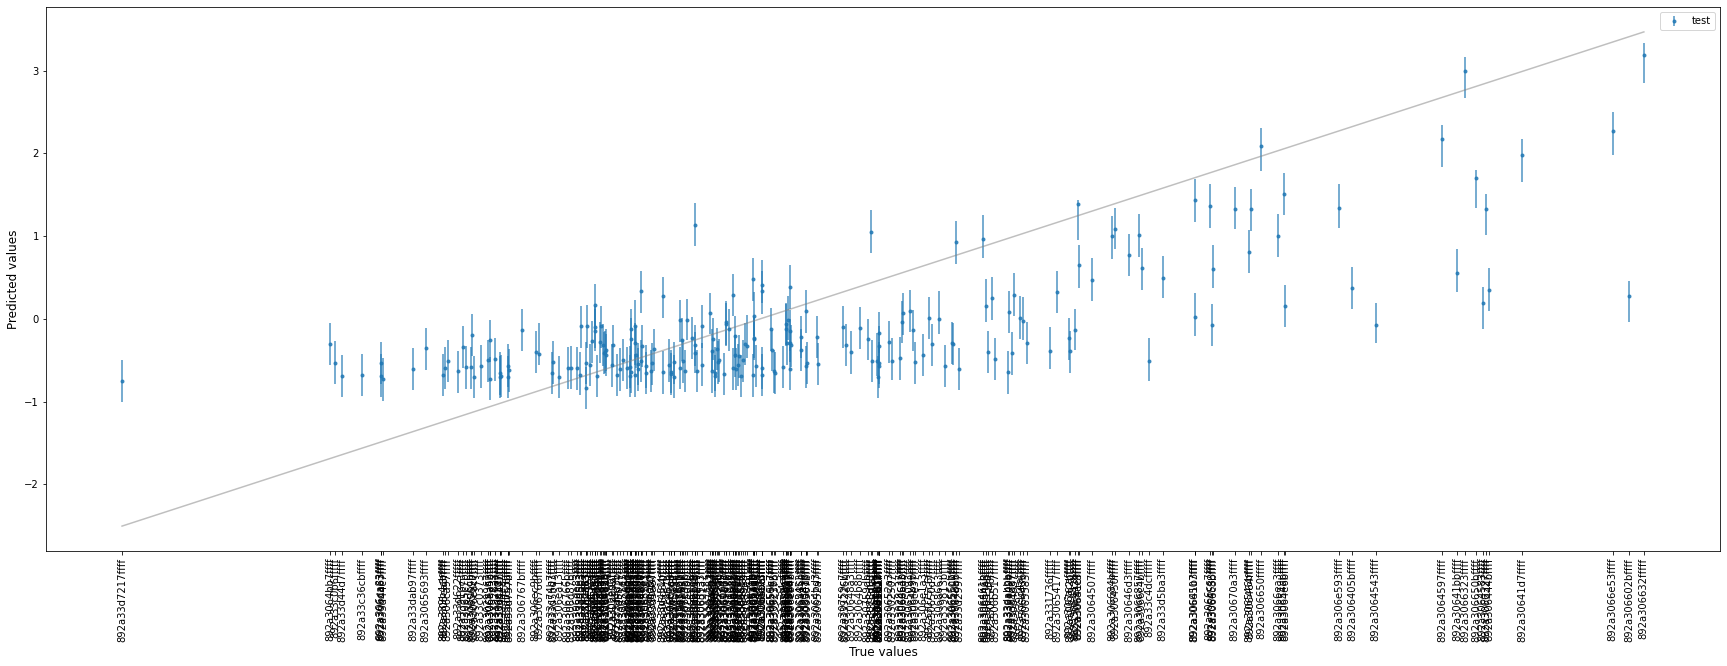

In [340]:
y_test_pred_low=y_test_pis[:, 0, alpha_plot]
y_test_pred_high=y_test_pis[:, 1, alpha_plot]

plt.figure(figsize=(30, 10))
plt.errorbar(
        x=y_test,
        y=y_test_pred,
        yerr=(y_test_pred - y_test_pred_low, y_test_pred_high - y_test_pred),
        alpha=0.8,
        label="test",
        fmt=".",
    )
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="gray",
    alpha=0.5,
)
# plt.scatter(x=y_test, y=y_test_pred_high - y_test_pred_low, alpha=0.8, label="test", marker=".")
plt.xlabel("True values", fontsize=12)
plt.ylabel("Predicted values", fontsize=12)
plt.xticks(y_test, labels=tt.X_test.index, rotation ='vertical')
plt.legend()

# plt.scatter(x=y_test, y=y_test_pred_high - y_test_pred_low, alpha=0.8, label="test", marker=".")
# ax2.set_xlabel("True values", fontsize=12)
# ax2.set_ylabel("Interval width", fontsize=12)
# ax2.set_xscale("linear")
# ax2.set_ylim([0, np.max(y_test_pred_high - y_test_pred_low)*1.1])
# ax2.legend()


In [375]:
# ### Plot the Predictions vs. Raw Data
# import plotly.express as px
# import plotly.graph_objects as go

# h3_index = hh.df.loc[hh.df['h3'].apply(lambda x: x in tt.X_test.index.values).values, 'h3']
# hh.df['h3'].apply(lambda x: x in tt.X_test.index.values)
# y_data = pd.DataFrame(data=np.exp(tt.scaler.Y.inverse_transform(tt.Y_test.loc.values.reshape(-1, 1)).reshape(-1)), index=h3_index, columns=['y_test'])
# y_data.reset_index(inplace=True)

# def plot_raw_for_alpha(y_data, y_pred, y_pls):

#     # get the inverse transform of the y_pred
    
#     y_data['y_pred'] = np.exp(tt.scaler.Y.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1))
#     y_data['y_pred_lb'] = np.exp(tt.scaler.Y.inverse_transform(y_pls[:, 0].reshape(-1, 1)).reshape(-1))
#     y_data['y_pred_ub'] = np.exp(tt.scaler.Y.inverse_transform(y_pls[:, 1].reshape(-1, 1)).reshape(-1))

#     # get the y_pred_df
#     y_pred_df = y_data.groupby('h3')[['y_pred', 'y_pred_lb', 'y_pred_ub']].first()

#     fig = go.Figure()

#     # sort the y_pred_df by the y_pred
#     y_pred_df.sort_index(inplace=True)
#     y_data.sort_values('h3', inplace=True)

#     fig.add_trace(
#         go.Scatter(
#             x=y_data['h3'],
#             y=y_data['y_test'],
#             mode="markers"
#         )
#     )

#     # add upper and lower bounds, with fill
#     fig.add_trace(
#         go.Scatter(
#             x=y_pred_df.index,
#             y=y_pred_df['y_pred_lb'],
#             mode="lines",
#             line=dict(width=0),
#             showlegend=False
#         )
#     )

#     fig.add_trace(
#         go.Scatter(
#             x=y_pred_df.index,
#             y=y_pred_df['y_pred_ub'],
#             fill="tonexty",
#             fillcolor="rgba(0,100,80,0.2)",
#             line=dict(width=0),
#             mode="lines",
#             showlegend=False
#         )
#     )

#     # add the predicted mean
#     fig.add_trace(
#         go.Scatter(
#             x=y_pred_df.index,
#             y=y_pred_df['y_pred'],
#             mode="markers",
#             marker=dict(color="rgba(255, 0, 0, 1)", size=10),
#         )
#     )

# plot_raw_for_alpha(y_data, y_test_pred, y_test_pis[:, :, alpha_plot])

## Trying to understand intra hex variance now

In [52]:
# difference between predicted and empiral distribution hexagon wise

# 1. using predictions from GP Regression model
import scipy

test_df = tt.X_test.copy()

# conversion of log mean and std to the original scale

true_empirical_pnts = hh.df.loc[hh.df['h3'].isin(test_df.index)].groupby('h3').apply(lambda x: x['planned_service_time'].values).values
test_df['actual_mean'], test_df['actual_std'] = np.array([x.mean() for x in true_empirical_pnts]), np.array([x.std() for x in true_empirical_pnts])

pred_mean_var = tt.scaler.Y.inverse_transform(np.c_[preds.mean, preds.variance**0.5])
pred_mean, pred_std = pred_mean_var[:,0], pred_mean_var[:,1]

/home/ext_navish_iitkgp_gmail_com/.local/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


ValueError: operands could not be broadcast together with shapes (240,2) (5,) (240,2) 

In [ ]:
y_pred_samples = np.exp(np.random.normal(loc=pred_mean.reshape(-1,1), scale=pred_std.reshape(-1,1), size=(test_df.shape[0], 10000)))
test_df['pred_mean'], test_df['pred_std'] = y_pred_samples.mean(axis=1), y_pred_samples.std(axis=1)

#### Wasserstein Distance between predicted distribution and empirical points: 

In [ ]:
waserstein_distance = []
for group in hh.df.loc[hh.df['h3'].isin(test_df.index)].groupby('h3'):
    id_ = test_df.index.get_loc(group[1]['h3'].tolist()[0])
    waserstein_distance.append([group[1]['h3'].tolist()[0],scipy.stats.wasserstein_distance(y_pred_samples[id_], true_empirical_pnts[id_])])

test_df = test_df.join(pd.DataFrame(waserstein_distance).set_index(0)).rename(columns={1:'wasserstein_distance'})

In [ ]:
hh.df.loc[hh.df['h3'].isin(test_df.index)][['lat','lng', 'planned_service_time']].to_csv('scatter_points.csv')

In [ ]:
test_df.head()

,amenity,amenity_bank,amenity_bench,amenity_bicycle_parking,amenity_bicycle_rental,amenity_cafe,amenity_fast_food,amenity_fire_station,amenity_fuel,amenity_library,...,water_reservoir,water_river,waterway,waterway_river,waterway_stream,actual_mean,actual_std,pred_mean,pred_std,wasserstein_distance
h3,,,,,,,,,,,,,,,,,,,,,
892a3028c37ffff,-0.347054,-0.160446,-0.148445,-0.120825,-0.156924,-0.165404,-0.203914,-0.148216,-0.205343,-0.167024,...,-0.097435,-0.179349,-0.339090,-0.157634,-0.309611,107.786957,55.889941,86.327932,62.736341,24.387393
892a302992fffff,-0.087881,-0.160446,-0.148445,-0.120825,-0.156924,-0.165404,-0.203914,-0.148216,-0.205343,-0.167024,...,-0.097435,-0.179349,2.832007,-0.157634,3.149114,76.829167,44.223358,107.208913,77.352479,31.031421
892a3029967ffff,-0.347054,-0.160446,-0.148445,-0.120825,-0.156924,-0.165404,-0.203914,-0.148216,-0.205343,-0.167024,...,-0.097435,-0.179349,-0.339090,-0.157634,-0.309611,70.007692,56.954921,106.077465,79.955557,36.157665
892a3029a57ffff,-0.087881,-0.160446,-0.148445,-0.120825,-0.156924,-0.165404,-0.203914,5.761894,-0.205343,-0.167024,...,-0.097435,-0.179349,-0.339090,-0.157634,-0.309611,79.075000,58.712883,107.430273,79.565246,28.711881
892a3060053ffff,-0.347054,-0.160446,-0.148445,-0.120825,-0.156924,-0.165404,-0.203914,-0.148216,-0.205343,-0.167024,...,-0.097435,-0.179349,-0.339090,-0.157634,-0.309611,78.826087,51.024847,84.078098,63.988594,11.737182


In [ ]:
largest_var_df = test_df.nlargest(100, 'wasserstein_distance')
smallest_var_df = test_df.nsmallest(100, 'wasserstein_distance')
largest_var_df.to_csv('intrahex_largest_var_df.csv')
smallest_var_df.to_csv('intrahex_smallest_var_df.csv')

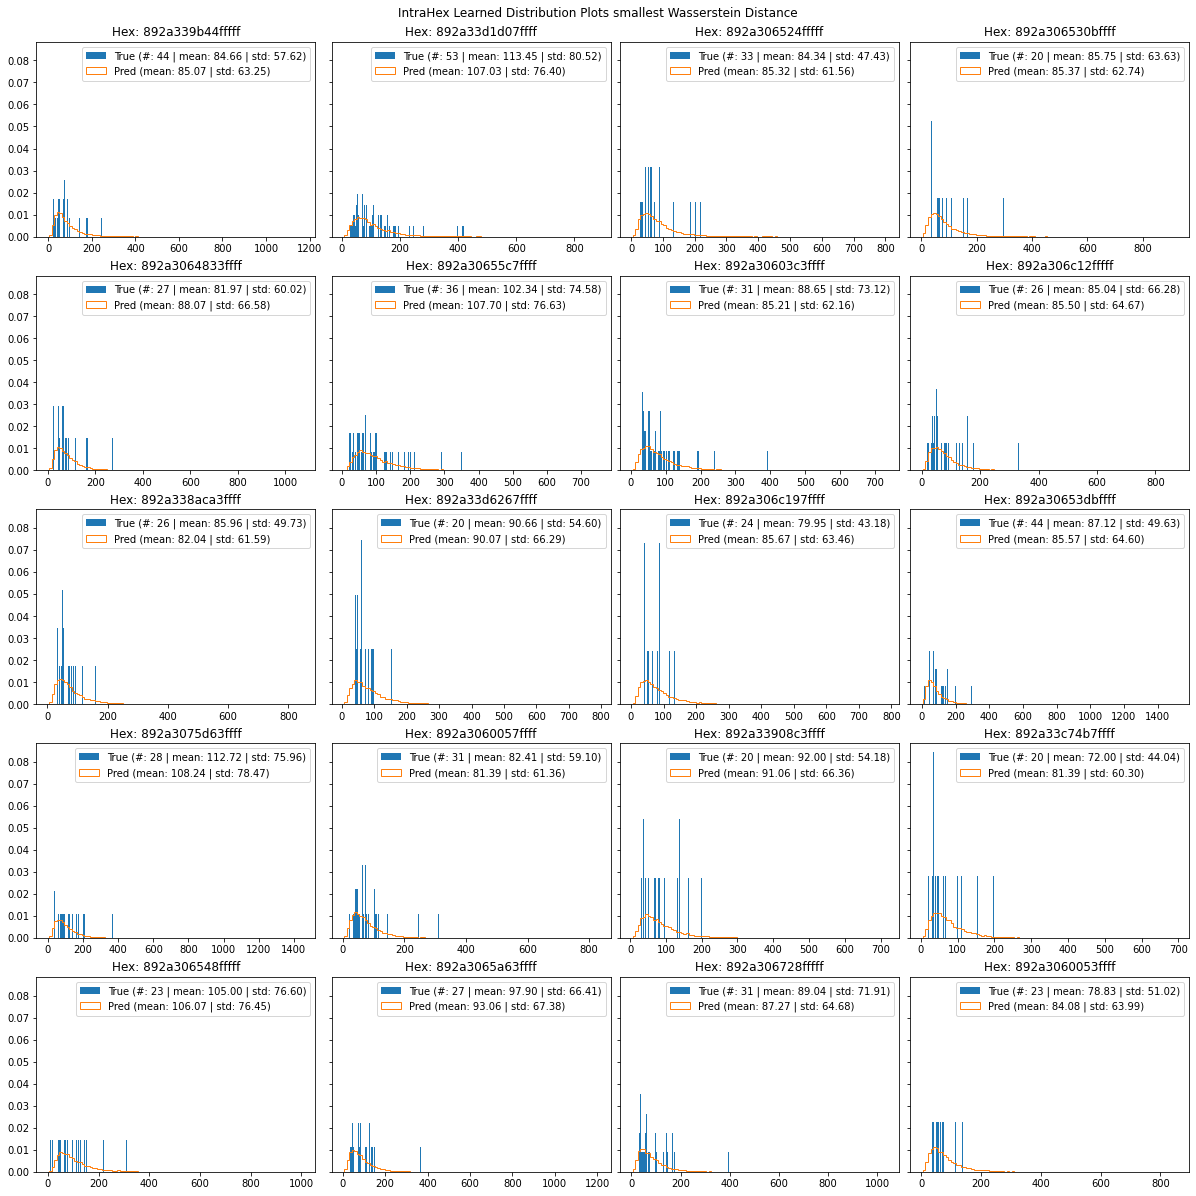

In [ ]:
plt.rcParams['figure.constrained_layout.use'] = True
def dist_subplots(df, title):
    rows, cols = 5, 4
    fig, axes = plt.subplots(rows, cols, figsize=(16.5, 16.5), sharey=True)
    fig.suptitle(title)
    count = 0
    for i in range(rows):
        for j in range(cols):
            # emp_pnts = hh.df.loc[hh.df['h3']==df.iloc[count].name]['planned_service_time'].to_list()
            # y_samples = np.random.normal(loc=df.iloc[count]['pred_mean'], scale=df.iloc[count]['pred_std'], size=10000,)
            # y_samples = np.clip(np.exp(y_samples), 0, 10000)
            id_ = test_df.index.get_loc(df.iloc[count].name)
            axes[i, j].hist(true_empirical_pnts[id_], bins=100, density=True, label=f'True (#: {len(true_empirical_pnts[id_])} | mean: {test_df.iloc[id_].actual_mean:.2f} | std: {test_df.iloc[id_].actual_std:.2f})')
            axes[i, j].hist(y_pred_samples[id_], bins=100, density=True, histtype='step', label=f'Pred (mean: {test_df.iloc[id_].pred_mean:.2f} | std: {test_df.iloc[id_].pred_std:.2f})')
            axes[i, j].set_title(f'Hex: {df.iloc[count].name}')
            axes[i, j].legend()
            # axes[i, j].set_ylim(0, 1)
            # axes[i, j].set_xlim(0, 1)
            count += 1
    plt.tight_layout()


dist_subplots(smallest_var_df, 'IntraHex Learned Distribution Plots smallest Wasserstein Distance')

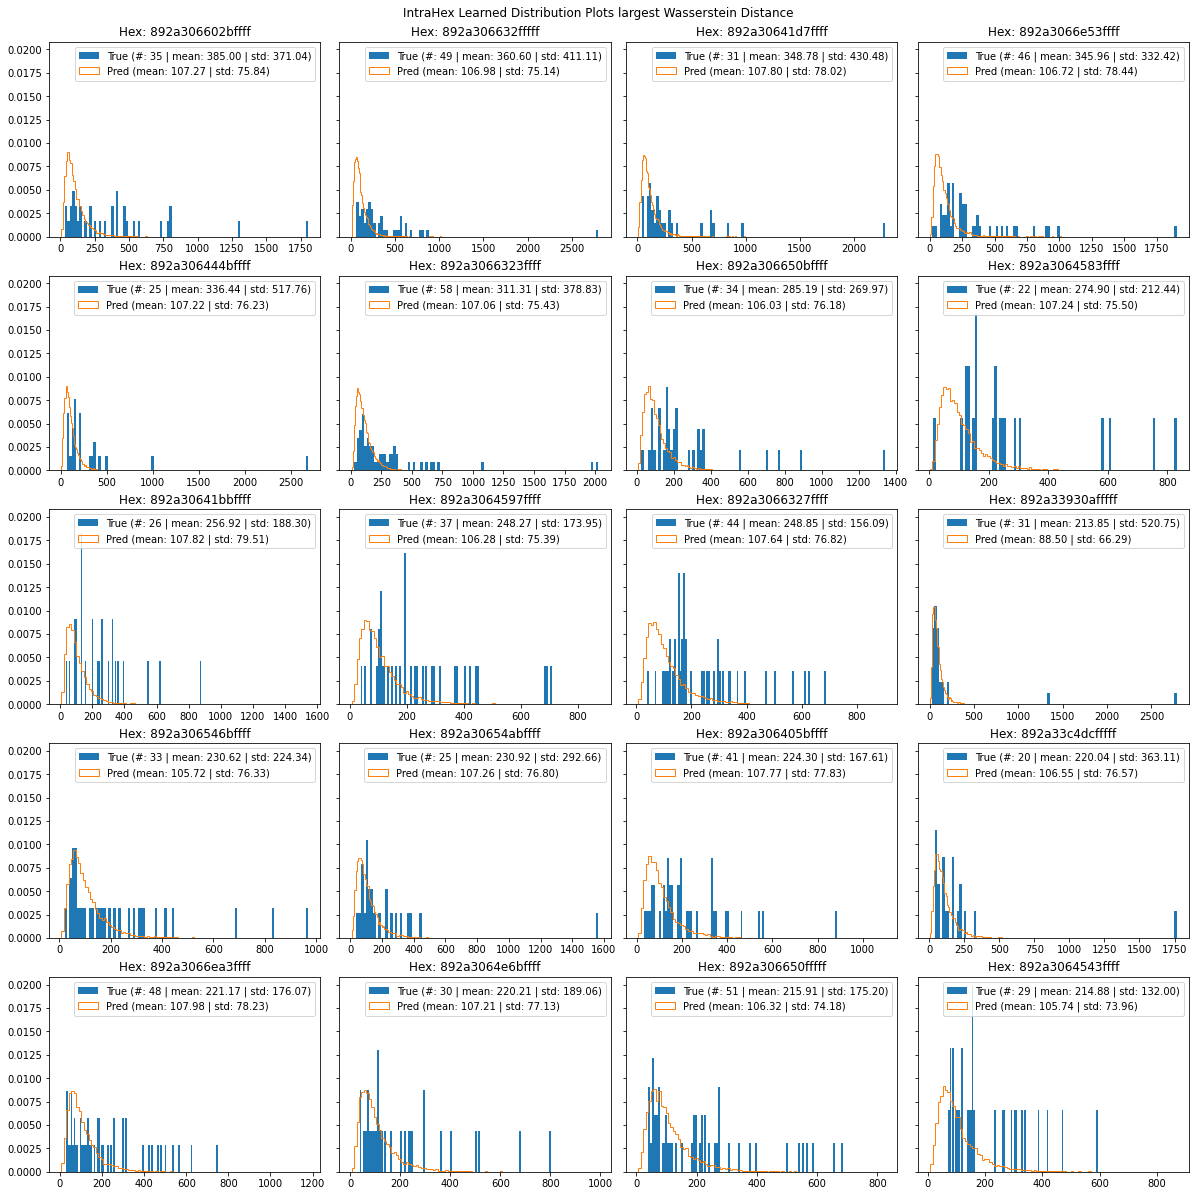

In [ ]:
dist_subplots(largest_var_df, 'IntraHex Learned Distribution Plots largest Wasserstein Distance')


### Plot wasserstein distance distribution

<AxesSubplot: title={'center': 'Wasserstein Distance Histogram'}, ylabel='Frequency'>

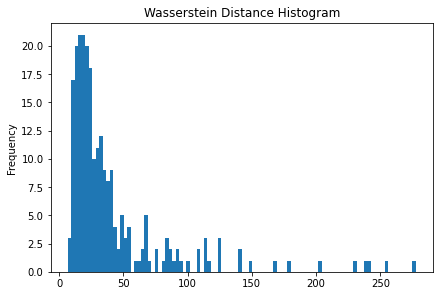

In [ ]:
test_df['wasserstein_distance'].plot.hist(bins=100, title='Wasserstein Distance Histogram')